# Jigsaw Unintended Bias in Toxicity Classification
## Détection de toxicité robuste et atténuation des biais d'identité

### Enoncé du problème
Les plateformes en lignes modèrent automatiquement les
commentaires pour limiter les messages haineux. Mais ces classifieurs de
toxicité présentent souvent un biais : ils ont tendance à considérer certains mots
liés à des identités ou communautés (par exemple « gay », « black », « muslim
») comme intrinsèquement toxiques. Cela entraîne une censure injuste qui
touche en priorité des groupes marginalisés.
Notre objectif est donc de développer un modèle de détection de la toxicité qui
reste efficace pour modérer les propos haineux, tout en réduisant au maximum
ces biais involontaires, afin de garantir une modération plus juste.

### Pertinence pour le Big Data

Le dataset contient environ 2.0 millions de
commentaires annotés avec des metadonnées sur les biais potentiels).
L’approche Big Data est nécessaire car :

Volume : 2.38GB de données dont environ 2.0 millions de commentaires
(texte libre) avec des colonnes de labels binaires et continus.
Variété :
- Données non struturées : texte brut nécessitant un prétraitement
lourd afin de pouvoir les exploiter
- Données structurées : variables numériques (binaires/continues)
liées aux biais (genre, religion, orientation sexuelle)
- Nécessite des pipelines capables d’intégrer ces différents types de
données

Vélocité : dans un scénario de déploiement, les plateformes en lignes
génèrent des flux continus de nouveaux commentaires
- Nécessite une modération en temps réel ce qui impose des
systèmes distribués de type stream processing pour l’ingestion, le
prétraitement des données et la classification

Limitations des approches traditionnelles : L’approche traditionnelle
Pandas/Scikit-learn qui fonctionne en mémoire sur un seul CPU est
inadapté pour l’entraînement sur plusieurs millions de commentaires en
texte brut. HDFS + Spark nous permettront de faire de la parallélisation
pour entraîner les NLP.

### Description de l'ensemble de données

Dataset Name: Jigsaw Unintended Bias in Toxicity Classification

Source: Compétition Kaggle https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/overview

Type of Data: Semi-structuré (texte brut en CSV + colonnes numériques,
binaires)

Volume: 2 millions de commentaires annotés ; 2.38GB de données dans tous
les fichiers

Key Features:
- comment_text : commentaires (texte brut)
- target : score de toxicité (0-1)
- l’ensembles des colonnes du dataset identity_individual_annotations (double entre 0 et 1 pour la plupart mais aussi timestamp, integer et string)

Activation de findspark 

imports spark 

création de la session Spark : 
- utilisation de tous les coeurs alloués à la vm
- on alloue 8g de RAM à spark

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
.master("local") \
.master("local[*]") \
.appName("Jigsaw Unintended Bias in Toxicity Classification") \
.config("spark.driver.memory", "8g") \
.config("spark.executor.memory", "8g") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/21 23:36:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/21 23:36:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


**Imports**: matplotlib pour les graphiques ; des fonctions de pyspark.sql ; des fonctions de pyspark.ml pour la création de pipeline ; nltk et WordNet Lemmatizer pour la lemmatisation ; PipelineModel pour le chargement et la sauvegarde d'un pipeline spark

In [2]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import isnan

from pyspark.sql.functions import udf, regexp_replace, lower, col, when, isnan
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, SQLTransformer
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk.stem import WordNetLemmatizer

import os
from pyspark.ml import PipelineModel

[nltk_data] Downloading package wordnet to /home/vboxuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vboxuser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 0. Chargement et inspection des données

In [3]:
train = spark.read.csv('../train.csv', header=True, inferSchema=True)
train.select("id", "target", "comment_text").show(5, truncate=False) # pas toutes les colonnes sinon illible 

+-----+------------------+------------------------------------------------------------------------------------------------------------------+
|id   |target            |comment_text                                                                                                      |
+-----+------------------+------------------------------------------------------------------------------------------------------------------+
|59848|0.0               |This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!             |
|59849|0.0               |Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!|
|59852|0.0               |This is such an urgent design problem; kudos to you for taking it on. Very impressive!                            |
|59855|0.0               |Is this something I'll be able to install on my site? When will you be releasing it?                              |
|59856

On print le schéma ainsi que la desccription de certaines colonnes pour vérifier si spark a correctement inféré les types des features

In [4]:
train.printSchema()

print(f"nombre de lignes : {train.count()}")
print(f"nombre de colonnes : {len(train.columns)}")
train.describe(['target', 'severe_toxicity', 'obscene', 'insult']).show()

root
 |-- id: string (nullable = true)
 |-- target: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- severe_toxicity: string (nullable = true)
 |-- obscene: string (nullable = true)
 |-- identity_attack: string (nullable = true)
 |-- insult: string (nullable = true)
 |-- threat: string (nullable = true)
 |-- asian: string (nullable = true)
 |-- atheist: string (nullable = true)
 |-- bisexual: string (nullable = true)
 |-- black: string (nullable = true)
 |-- buddhist: string (nullable = true)
 |-- christian: string (nullable = true)
 |-- female: string (nullable = true)
 |-- heterosexual: string (nullable = true)
 |-- hindu: string (nullable = true)
 |-- homosexual_gay_or_lesbian: string (nullable = true)
 |-- intellectual_or_learning_disability: string (nullable = true)
 |-- jewish: string (nullable = true)
 |-- latino: string (nullable = true)
 |-- male: string (nullable = true)
 |-- muslim: string (nullable = true)
 |-- other_disability: string (nullable = t

nombre de lignes : 3053644
nombre de colonnes : 45


25/11/21 23:36:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 6:==================================================>        (6 + 1) / 7]

+-------+-----------------+------------------+-------------------+------------------+
|summary|           target|   severe_toxicity|            obscene|            insult|
+-------+-----------------+------------------+-------------------+------------------+
|  count|          2675011|           1952476|            1884541|           1599964|
|   mean| 1.39617704209127|0.5229622220223501|0.27979058176251326|0.1588871465791632|
| stddev|95.57281390041796| 29.97467979690922| 20.856200441619187|12.442404028199363|
|    min|               \t|                  |                   |                  |
|    max|              😀"|        … you know|   … heroes three."|            ”. Wow|
+-------+-----------------+------------------+-------------------+------------------+



Problème : on a des données non numériques dans ces colonnes --> données mal parsées ; de plus on a dans le schéma : type string au lieu d'un type numérique, ce qui confirme notre intuition. Nous réadaptons le script en conséquence :

In [5]:
train = (
    spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .option("multiLine", True) # commentaires multilignes
    .option("escape", "\"") # les " internes à un comment ne ferment pas le champ
    .load("../train.csv")
)

In [6]:
train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- target: double (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- severe_toxicity: double (nullable = true)
 |-- obscene: double (nullable = true)
 |-- identity_attack: double (nullable = true)
 |-- insult: double (nullable = true)
 |-- threat: double (nullable = true)
 |-- asian: double (nullable = true)
 |-- atheist: double (nullable = true)
 |-- bisexual: double (nullable = true)
 |-- black: double (nullable = true)
 |-- buddhist: double (nullable = true)
 |-- christian: double (nullable = true)
 |-- female: double (nullable = true)
 |-- heterosexual: double (nullable = true)
 |-- hindu: double (nullable = true)
 |-- homosexual_gay_or_lesbian: double (nullable = true)
 |-- intellectual_or_learning_disability: double (nullable = true)
 |-- jewish: double (nullable = true)
 |-- latino: double (nullable = true)
 |-- male: double (nullable = true)
 |-- muslim: double (nullable = true)
 |-- other_disability: double (nullable = 

In [7]:
print(f"nombre de lignes : {train.count()}")
print(f"nombre de colonnes : {len(train.columns)}")
train.describe(['target', 'severe_toxicity', 'obscene', 'insult']).show()

nombre de lignes : 1804874
nombre de colonnes : 45


[Stage 14:>                                                         (0 + 1) / 1]

+-------+-------------------+--------------------+--------------------+-------------------+
|summary|             target|     severe_toxicity|             obscene|             insult|
+-------+-------------------+--------------------+--------------------+-------------------+
|  count|            1804874|             1804874|             1804874|            1804874|
|   mean|0.10301729306264126|0.004582098790397937|0.013877209195019816|0.08115273414475882|
| stddev|0.19707574479033887| 0.02286128244247058|  0.0646041914397229|0.17606571372957508|
|    min|                0.0|                 0.0|                 0.0|                0.0|
|    max|                1.0|                 1.0|                 1.0|                1.0|
+-------+-------------------+--------------------+--------------------+-------------------+



Les features ont été correctement inférées. La moyenne ainsi que l'écart type de ces features nous renseigne quand à un fort déséquilibre des classes, que nous approfondirons par la suite

In [8]:
train.limit(20).toPandas().head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


A l'aide du schéma on identifie des groupes dans les features :

- La colonne commentaires --> **string**
- La colonne target --> **double entre [0,1]**
- Les sous-labels de toxicité --> **double entre [0,1]** : <span style="color:green;">severe_toxicity, obscene, identity_attack, insult, threat, sexual_explicit
</span>



- Les colonnes d'identité --> **float entre [0,1]** : <span style="color:green;">asian, atheist, bisexual, black, buddhist, christian, female, heterosexual, hindu, homosexual_gay_or_lesbian, intellectual_or_learning_disability, jewish, latino, male, muslim, other_disability, other_gender, other_race_or_ethnicity, other_religion, other_sexual_orientation, physical_disability, psychiatric_or_mental_illness, transgender, white</span>
 
- Les colonnes temporelles --> **timestamp** : <span style="color:green;">created_date</span>


- Les features liées aux métadonnées --> **numériques mais catégorielles** : <span style="color:green;">publication_id, parent_id, article_id</span>

- Colonnes liées aux réactions --> compteurs d’interactions, **int** : <span style="color:green;">funny, wow, sad, likes, disagree</span>

- Nombre d'annotateurs sur un commentaire donné (mesure de la confiance des labels) --> **int** : <span style="color:green;">identity_annotator_count, toxicity_annotator_count</span>

*Nous allons explorer les distributions de toutes ces colonnes. Sont affichées ci-dessous tous les distributions pour chaque feature représentative d'un groupe*


Fonction pour afficher la distribution d'une col numerique + nb valeurs manquantes

In [9]:
def describe_col(spark_df, column_name, bins = 50):
    """
    Affiche la distribution d'une col numerique + nb valeurs manquantes
    """
    data = spark_df.select(column_name).toPandas()
    
    plt.figure(figsize=(8, 5))
    plt.hist(data[column_name], bins=bins, edgecolor='black')
    plt.title(f"Distribution de '{column_name}'")
    plt.xlabel(column_name)
    plt.ylabel("Fréquence")
    plt.grid(True, alpha=0.3)
    plt.show()

    tot = spark_df.count()

    dtype = dict(spark_df.dtypes)[column_name]

    if dtype in ("double", "float"):
        missing = spark_df.filter(
            col(column_name).isNull() | isnan(col(column_name))
        ).count()
    else:
        missing = spark_df.filter(
            col(column_name).isNull()
        ).count()

    missing_pct = (missing / tot) * 100
    print(f"Valeurs manquantes : {missing} / {tot} ({missing_pct:.2f}%)")

In [10]:
from pyspark.sql.functions import col, isnan, lit
import numpy as np

def preview_comments(df, col_name, comment_col="comment_text", max_categories=5, bins=5, per_group=3):
    """
    Aperçu des commentaires :
    - Si nombre de valeurs distinctes inf ou egal à max_categories --> catégoriel
    - Sinon --> continu, on fait des bins
    --> Affiche un tableau récapitulatif des effectifs
    """

    # On compte le nb de valeurs distinctes
    distinct_vals = df.select(col_name).distinct().dropna().collect()
    distinct_count = len(distinct_vals)

    print(f"Nombre de valeurs distinctes : {distinct_count}\n")

    # VARIABLE CATÉGORIELLE
    if distinct_count <= max_categories:
        print("--> Colonne détectée comme CATEGORIELLE\n")

        values = [row[col_name] for row in distinct_vals]

        # tableau des effectifs 
        summary_rows = []
        for v in values:
            count_v = df.filter(col(col_name) == v).count()
            summary_rows.append((str(v), count_v))

        summary_df = spark.createDataFrame(summary_rows, ["Categorie", "Effectif"])
        print("Tableau des effectifs par catégorie :")
        summary_df.show(truncate=False)

        print("\nAperçu des commentaires par catégorie :\n")

        for v in values:
            print(f">> Valeur : {v} ")
            subset = df.filter(col(col_name) == v)
            subset.select(col_name, comment_col).show(per_group, truncate=100)
            print("\n")

        return


    # VARIABLE CONTINUE
    print("--> Colonne détectée comme CONTINUE (ou + de 5 catégories). Création de bins.\n")

    # on cherche min/max
    values = df.select(col_name).dropna().rdd.map(lambda r: r[0]).collect()
    mn, mx = min(values), max(values)

    print(f"Range = [{mn:.4f}, {mx:.4f}]\n")

    edges = np.linspace(mn, mx, bins + 1)

    # tableau des effectifs par bin 
    summary_rows = []

    for i in range(bins):
        low, high = float(edges[i]), float(edges[i+1])

        # Tous les bins sauf le dernier : [low, high)
        if i < bins - 1:
            subset = df.filter((col(col_name) >= low) & (col(col_name) < high))
        else:
            # Dernier bin : inclut la valeur max --> sinon on a pas les val avec 1.0 quand les valeurs sont entre [0,1]
            subset = df.filter((col(col_name) >= low) & (col(col_name) <= high))

        count_bin = subset.count()
        summary_rows.append((f"[{low:.4f}, {high:.4f}]", count_bin))

    summary_df = spark.createDataFrame(summary_rows, ["Intervalle", "Effectif"])

    print("Tableau des effectifs par intervalle :")
    summary_df.show(truncate=False)
    print("\nAperçu des commentaires par bin :\n")


    # Affichage des commentaires par bin
    for i in range(bins):
        low, high = float(edges[i]), float(edges[i+1])
        print(f">> Intervalle {i+1}/{bins} : [{low:.4f}, {high:.4f}] ")

        if i < bins - 1:
            subset = df.filter((col(col_name) >= low) & (col(col_name) < high))
        else:
            subset = df.filter((col(col_name) >= low) & (col(col_name) <= high))

        subset.select(col_name, comment_col).show(per_group, truncate=100)
        print("\n")

In [11]:
from pyspark.sql.functions import col

def explore_categorical(df, col_name="rating", comment_col="comment_text", per_group=5):
    print(f">> Exploration de la colonne catégorielle : {col_name} \n")

    # Valeurs distinctes + effectifs
    summary = (
        df.groupBy(col_name)
          .count()
          .orderBy(col("count").desc())
    )

    print("Valeurs et effectifs :")
    summary.show(truncate=False)

    # Aperçu des exemples par catégorie
    categories = [row[col_name] for row in summary.collect()]

    print("\n>> Aperçu des commentaires par catégorie \n")
    for cat in categories:
        print(f">> {col_name} = '{cat}'")
        df.filter(col(col_name) == cat) \
          .select(col_name, comment_col) \
          .show(per_group, truncate=100)
        print("\n")


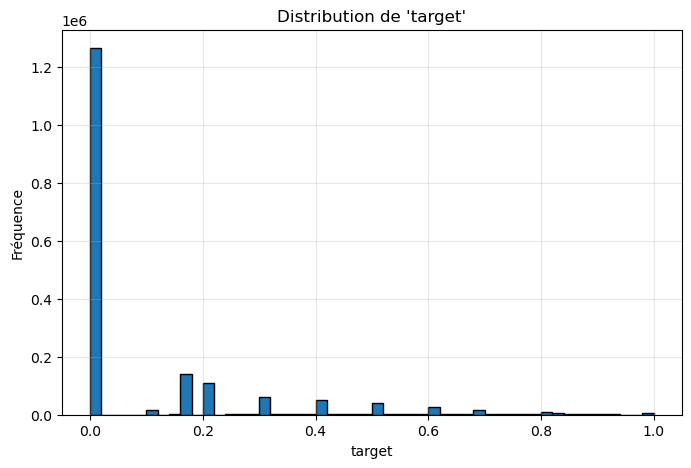

Valeurs manquantes : 0 / 1804874 (0.00%)


Nombre de valeurs distinctes : 2913

--> Colonne détectée comme CONTINUE (ou + de 5 catégories). Création de bins.



Range = [0.0000, 1.0000]



Tableau des effectifs par intervalle :
+----------------+--------+
|Intervalle      |Effectif|
+----------------+--------+
|[0.0000, 0.2000]|1427188 |
|[0.2000, 0.4000]|176210  |
|[0.4000, 0.6000]|129241  |
|[0.6000, 0.8000]|41404   |
|[0.8000, 1.0000]|30831   |
+----------------+--------+


Aperçu des commentaires par bin :

>> Intervalle 1/5 : [0.0000, 0.2000] 
+------+----------------------------------------------------------------------------------------------------+
|target|                                                                                        comment_text|
+------+----------------------------------------------------------------------------------------------------+
|   0.0|This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well d...|
|   0.0|Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone...|
|   0.0|              This is such an urgent design problem; kudos to you for taking

In [12]:
describe_col(train, column_name="target")
preview_comments(train, "target")

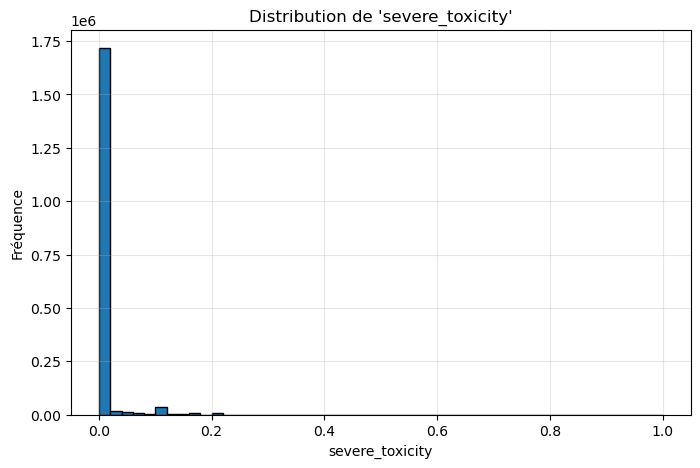

Valeurs manquantes : 0 / 1804874 (0.00%)


Nombre de valeurs distinctes : 1460

--> Colonne détectée comme CONTINUE (ou + de 5 catégories). Création de bins.



Range = [0.0000, 1.0000]



Tableau des effectifs par intervalle :
+----------------+--------+
|Intervalle      |Effectif|
+----------------+--------+
|[0.0000, 0.2000]|1798436 |
|[0.2000, 0.4000]|6363    |
|[0.4000, 0.6000]|73      |
|[0.6000, 0.8000]|1       |
|[0.8000, 1.0000]|1       |
+----------------+--------+


Aperçu des commentaires par bin :

>> Intervalle 1/5 : [0.0000, 0.2000] 
+---------------+----------------------------------------------------------------------------------------------------+
|severe_toxicity|                                                                                        comment_text|
+---------------+----------------------------------------------------------------------------------------------------+
|            0.0|This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well d...|
|            0.0|Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone...|
|            0.0|              This is 

+------------------+----------------------------------------------------------------------------------------------------+
|   severe_toxicity|                                                                                        comment_text|
+------------------+----------------------------------------------------------------------------------------------------+
|0.6443629697525206|You are murdering feckless SCUM.  Your mother would slap you for being the piece of shit that you...|
+------------------+----------------------------------------------------------------------------------------------------+



>> Intervalle 5/5 : [0.8000, 1.0000] 


[Stage 85:>                                                         (0 + 1) / 1]

+---------------+----------------------------------------------------------------------------------------------------+
|severe_toxicity|                                                                                        comment_text|
+---------------+----------------------------------------------------------------------------------------------------+
|            1.0|Awesome! Lets cut the head off hate! Lets stab it and burn its house down! lets march together an...|
+---------------+----------------------------------------------------------------------------------------------------+





In [13]:
describe_col(train, "severe_toxicity")
preview_comments(train, "severe_toxicity")


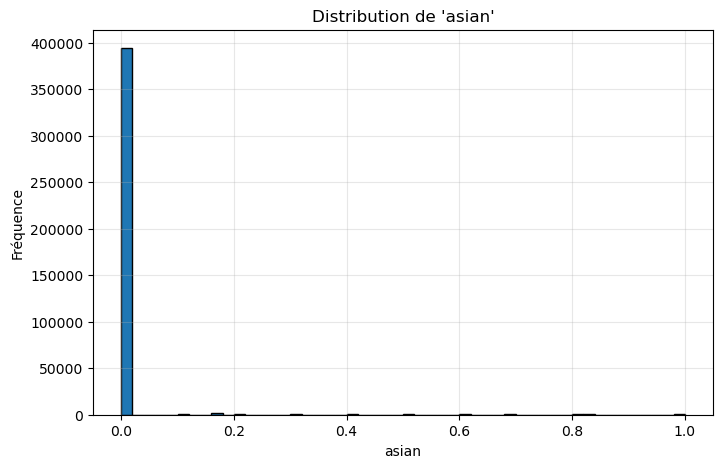

Valeurs manquantes : 1399744 / 1804874 (77.55%)


Nombre de valeurs distinctes : 125

--> Colonne détectée comme CONTINUE (ou + de 5 catégories). Création de bins.



Range = [0.0000, 1.0000]



Tableau des effectifs par intervalle :
+----------------+--------+
|Intervalle      |Effectif|
+----------------+--------+
|[0.0000, 0.2000]|397084  |
|[0.2000, 0.4000]|2402    |
|[0.4000, 0.6000]|2820    |
|[0.6000, 0.8000]|553     |
|[0.8000, 1.0000]|2271    |
+----------------+--------+


Aperçu des commentaires par bin :

>> Intervalle 1/5 : [0.0000, 0.2000] 
+-----+----------------------------------------------------------------------------------------------------+
|asian|                                                                                        comment_text|
+-----+----------------------------------------------------------------------------------------------------+
|  0.0|                                                                haha you guys are a bunch of losers.|
|  0.0|This is a great story. Man. I wonder if the person who yelled "shut the fuck up!" at him ever hea...|
|  0.0|Angry trolls, misogynists and Racists", oh my. It doesn't take all of my 150 IQ to

In [14]:
describe_col(train, "asian")
preview_comments(train, "asian")


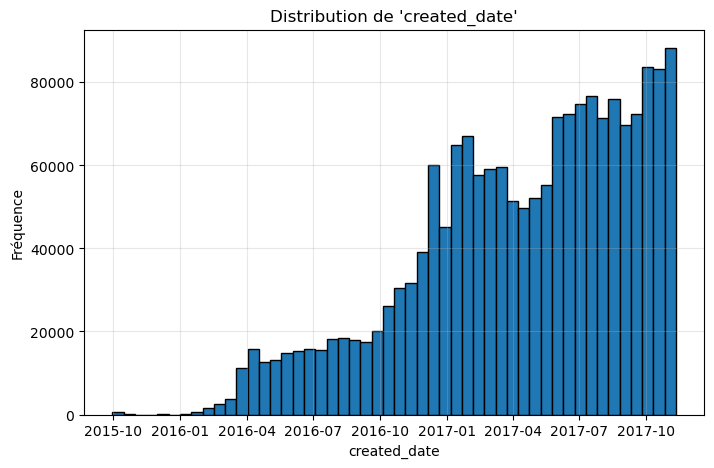

[Stage 124:>                                                        (0 + 1) / 1]

Valeurs manquantes : 0 / 1804874 (0.00%)


In [15]:
describe_col(train, "created_date")

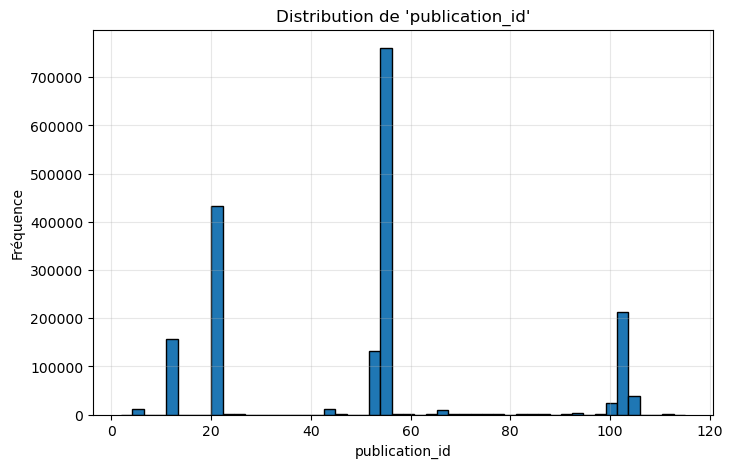

[Stage 131:>                                                        (0 + 1) / 1]

Valeurs manquantes : 0 / 1804874 (0.00%)


In [16]:
describe_col(train, "publication_id")

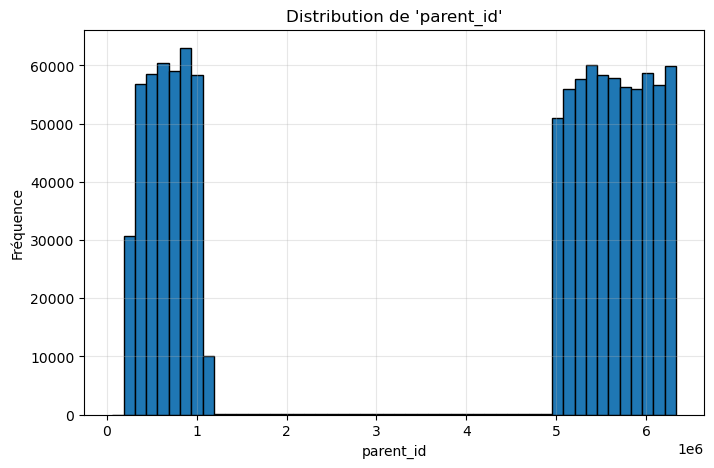

[Stage 138:>                                                        (0 + 1) / 1]

Valeurs manquantes : 778646 / 1804874 (43.14%)


In [17]:
describe_col(train, "parent_id")

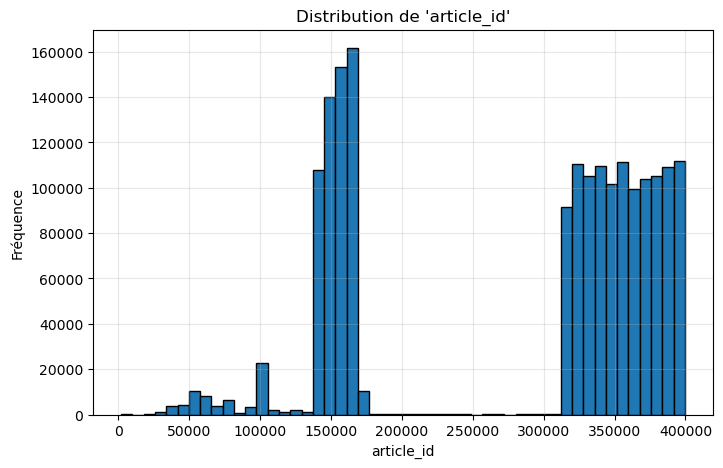

[Stage 145:>                                                        (0 + 1) / 1]

Valeurs manquantes : 0 / 1804874 (0.00%)


In [18]:
describe_col(train, "article_id")

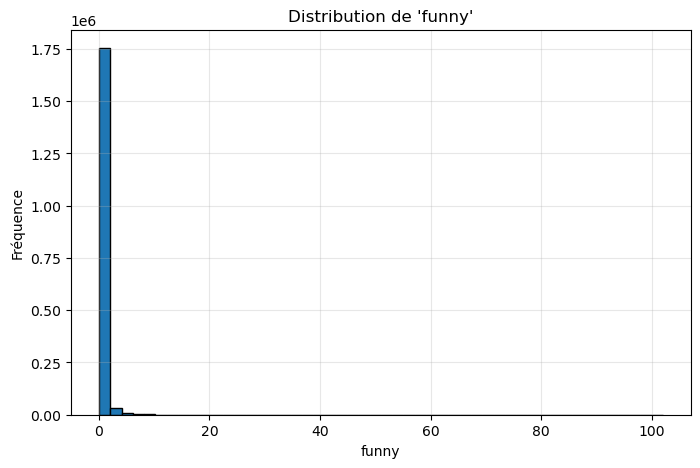

Valeurs manquantes : 0 / 1804874 (0.00%)


Nombre de valeurs distinctes : 61

--> Colonne détectée comme CONTINUE (ou + de 5 catégories). Création de bins.



Range = [0.0000, 102.0000]



Tableau des effectifs par intervalle :
+-------------------+--------+
|Intervalle         |Effectif|
+-------------------+--------+
|[0.0000, 20.4000]  |1804531 |
|[20.4000, 40.8000] |309     |
|[40.8000, 61.2000] |29      |
|[61.2000, 81.6000] |1       |
|[81.6000, 102.0000]|4       |
+-------------------+--------+


Aperçu des commentaires par bin :

>> Intervalle 1/5 : [0.0000, 20.4000] 
+-----+----------------------------------------------------------------------------------------------------+
|funny|                                                                                        comment_text|
+-----+----------------------------------------------------------------------------------------------------+
|    0|This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well d...|
|    0|Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone...|
|    0|              This is such an urgent design problem; k

+-----+----------------------------------------------------------------------------------------------------+
|funny|                                                                                        comment_text|
+-----+----------------------------------------------------------------------------------------------------+
|   23|Wait for it:   Trump will step down and let his children run his business.     \n\nA future Trump...|
|   24|So, I hear there are a lot of people saying that Amy is a bigot.  I'm not saying that I think tha...|
|   26|       It's because Trump knows more than the intelligence community. He is an expert on everything.|
+-----+----------------------------------------------------------------------------------------------------+
only showing top 3 rows


>> Intervalle 3/5 : [40.8000, 61.2000] 


+-----+----------------------------------------------------------------------------------------------------+
|funny|                                                                                        comment_text|
+-----+----------------------------------------------------------------------------------------------------+
|   52|                                                    Putin to release Trumps Tax returns. Coming soon|
|   43|....the spokesperson went on to say that anyone who would like  to represent the PM in Davos is w...|
|   50|Trump is indeed cutting costs.  Like how he's going to get Mexico to pay for the wall.  The U.S. ...|
+-----+----------------------------------------------------------------------------------------------------+
only showing top 3 rows


>> Intervalle 4/5 : [61.2000, 81.6000] 


+-----+----------------------------------------------------------------------------------------------------+
|funny|                                                                                        comment_text|
+-----+----------------------------------------------------------------------------------------------------+
|   73|I'm sure prospective migrants will now think twice about trying to enter Canada knowing that Libe...|
+-----+----------------------------------------------------------------------------------------------------+



>> Intervalle 5/5 : [81.6000, 102.0000] 


[Stage 181:>                                                        (0 + 1) / 1]

+-----+-----------------------------------------------------------+
|funny|                                               comment_text|
+-----+-----------------------------------------------------------+
|  102|          It will run you $1500 for a double double though.|
|   94|Kevin considers himself quite the wit, and he's half right.|
|   93|                     Congrats to Harjit Sajjan - nice shot!|
+-----+-----------------------------------------------------------+
only showing top 3 rows




In [19]:
describe_col(train, "funny")
preview_comments(train, "funny")

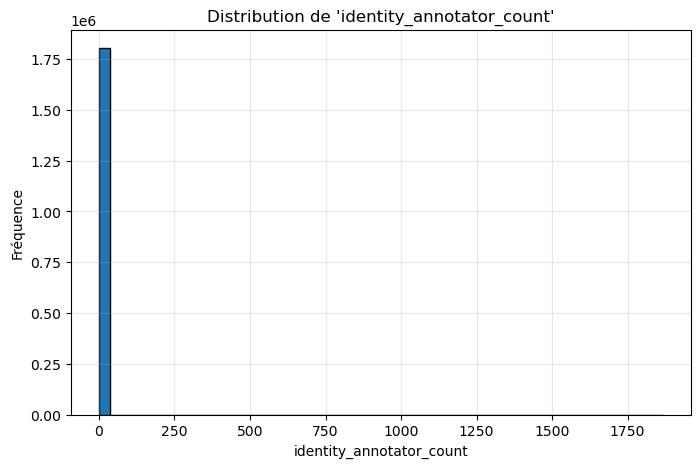

Valeurs manquantes : 0 / 1804874 (0.00%)


Nombre de valeurs distinctes : 158

--> Colonne détectée comme CONTINUE (ou + de 5 catégories). Création de bins.



Range = [0.0000, 1866.0000]



Tableau des effectifs par intervalle :
+----------------------+--------+
|Intervalle            |Effectif|
+----------------------+--------+
|[0.0000, 373.2000]    |1804659 |
|[373.2000, 746.4000]  |1       |
|[746.4000, 1119.6000] |0       |
|[1119.6000, 1492.8000]|40      |
|[1492.8000, 1866.0000]|174     |
+----------------------+--------+


Aperçu des commentaires par bin :

>> Intervalle 1/5 : [0.0000, 373.2000] 
+------------------------+----------------------------------------------------------------------------------------------------+
|identity_annotator_count|                                                                                        comment_text|
+------------------------+----------------------------------------------------------------------------------------------------+
|                       0|This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well d...|
|                       0|Thank you!! This would make my life a lo

+------------------------+----------------------------------------------------------------------------------------------------+
|identity_annotator_count|                                                                                        comment_text|
+------------------------+----------------------------------------------------------------------------------------------------+
|                     408|Taqiyya is the Islamic practice of deception. It can take the form of concealing the full truth (...|
+------------------------+----------------------------------------------------------------------------------------------------+



>> Intervalle 3/5 : [746.4000, 1119.6000] 


+------------------------+------------+
|identity_annotator_count|comment_text|
+------------------------+------------+
+------------------------+------------+



>> Intervalle 4/5 : [1119.6000, 1492.8000] 
+------------------------+----------------------------------------------------------------------------------------------------+
|identity_annotator_count|                                                                                        comment_text|
+------------------------+----------------------------------------------------------------------------------------------------+
|                    1226|My understanding is that a PPS employee/fundamentalist Christian complained because Frida is bise...|
|                    1267|I really hope that this event will be able to be back next year with the city trying to ban these...|
|                    1257|With all due respect to Nick, how does he know they are lesbians and not bisexual? And if they ha...|
+------------------------

In [20]:
describe_col(train, "identity_annotator_count")
preview_comments(train, "identity_annotator_count")

In [21]:
explore_categorical(train, "rating", comment_col="comment_text")

>> Exploration de la colonne catégorielle : rating 

Valeurs et effectifs :


+--------+-------+
|rating  |count  |
+--------+-------+
|approved|1684758|
|rejected|120116 |
+--------+-------+




>> Aperçu des commentaires par catégorie 

>> rating = 'approved'
+--------+----------------------------------------------------------------------------------------------------+
|  rating|                                                                                        comment_text|
+--------+----------------------------------------------------------------------------------------------------+
|approved|The ranchers seem motivated by mostly by greed; no one should have the right to allow their anima...|
|approved|                    It was a great show. Not a combo I'd of expected to be good together but it was.|
|approved|                                                                             Wow, that sounds great.|
|approved|This is a great story. Man. I wonder if the person who yelled "shut the fuck up!" at him ever hea...|
|approved|                                                      This seems like a step in the right direction.|
+--------+---------------------------

In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap_with_col(df, col_main, other_cols, method="pearson", sample_fraction=0.1, seed=42):
    """
    Affiche une heatmap de corrélation entre col_main et d'autres colonnes.
    """
    cols = [col_main] + other_cols
    
    # Échantillonnage pour rapidité
    sampled_df = df.select(cols).dropna().sample(fraction=sample_fraction, seed=seed)
    
    # Convertir en pandas
    pdf = sampled_df.toPandas()
    
    # Calculer la corrélation
    corr_matrix = pdf.corr(method=method)
    
    # Extraire uniquement la colonne principale vs les autres
    corr_series = corr_matrix[col_main].drop(col_main)
    
    # Affichage heatmap
    plt.figure(figsize=(8, max(4, len(other_cols)*0.5)))
    sns.heatmap(corr_series.to_frame(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"Correlation avec {col_main}")
    plt.show()


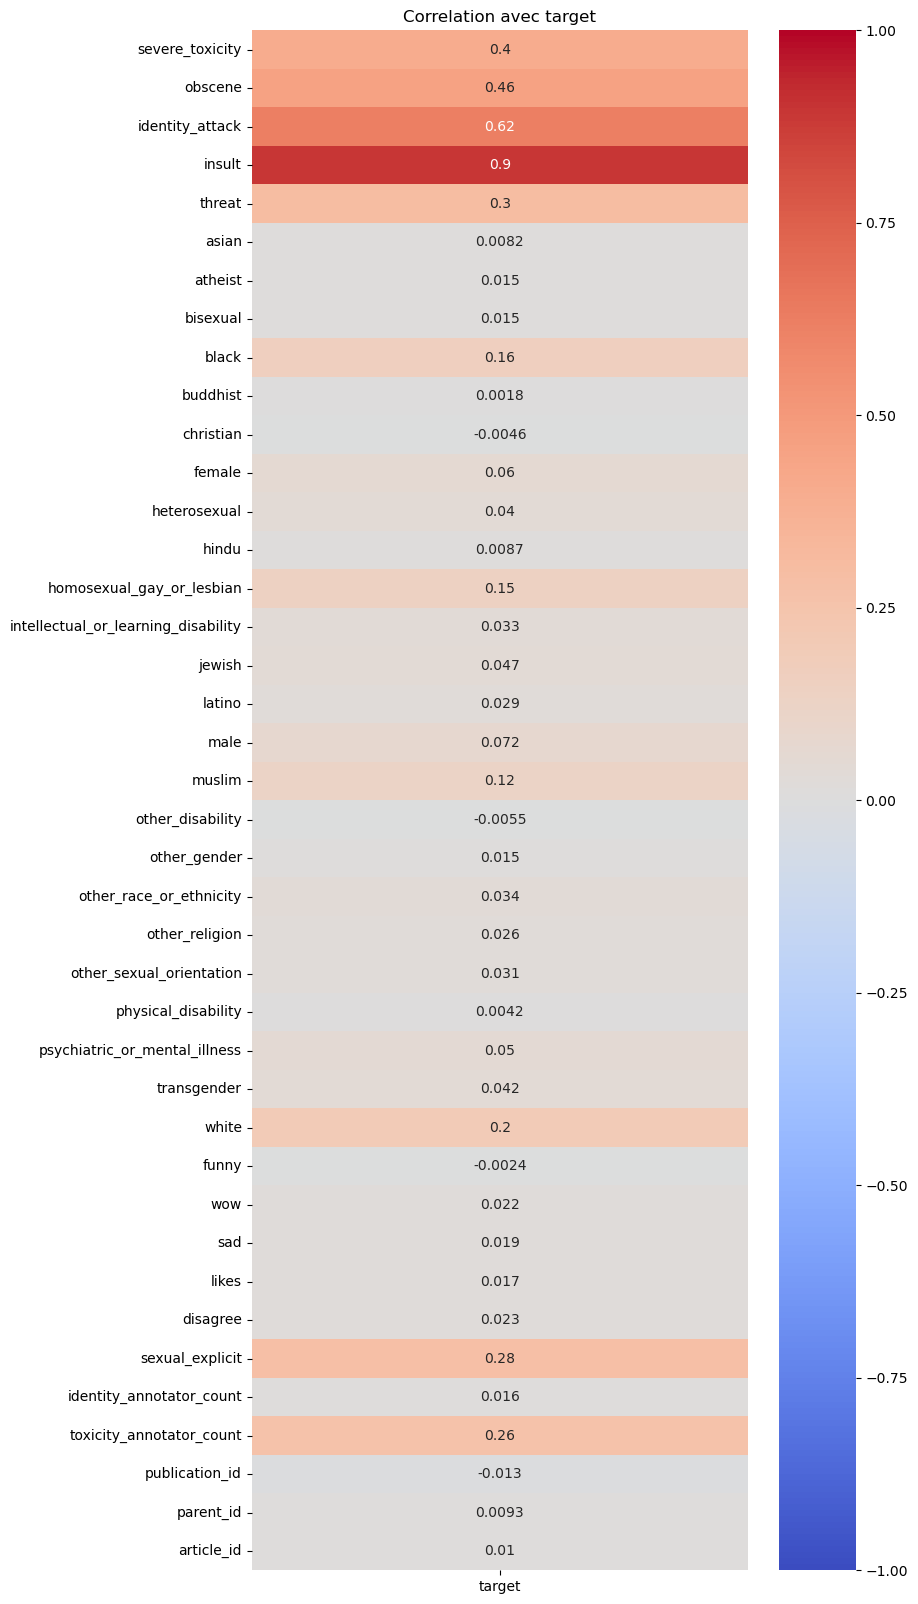

In [23]:
numeric_cols = [
    "severe_toxicity", "obscene", "identity_attack", "insult", "threat",
    "asian", "atheist", "bisexual", "black", "buddhist", "christian",
    "female", "heterosexual", "hindu", "homosexual_gay_or_lesbian",
    "intellectual_or_learning_disability", "jewish", "latino", "male",
    "muslim", "other_disability", "other_gender", "other_race_or_ethnicity",
    "other_religion", "other_sexual_orientation", "physical_disability",
    "psychiatric_or_mental_illness", "transgender", "white",
    "funny", "wow", "sad", "likes", "disagree", "sexual_explicit",
    "identity_annotator_count", "toxicity_annotator_count",
    "publication_id", "parent_id", "article_id"
]

heatmap_with_col(train, "target", numeric_cols, sample_fraction=0.1)

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def scatter_plot(df, col_x, col_y, sample_fraction=0.1, seed=42, title=None, show_regression=True):
    """
    Affiche un scatter plot entre deux colonnes numériques et éventuellement la droite de régression.
    """
    # echantillonage
    sampled_df = df.select(col_x, col_y).dropna().sample(fraction=sample_fraction, seed=seed)
    
    # on passe en pandas
    pdf = sampled_df.toPandas()
    
    plt.figure(figsize=(6,5))
    plt.scatter(pdf[col_x], pdf[col_y], alpha=0.6, s=20, label="Données")

    # droite de regression 
    if show_regression:
        x = pdf[col_x].values
        y = pdf[col_y].values
        if len(x) > 1:
            m, b = np.polyfit(x, y, 1)  # régression linéaire y = m*x + b
            plt.plot(x, m*x + b, color='red', lw=2, label=f"y={m:.2f}x+{b:.2f}")

    plt.xlabel(col_x)
    plt.ylabel(col_y)
    if title:
        plt.title(title)
    else:
        plt.title(f"Scatter plot : {col_x} vs {col_y}")
    plt.grid(True)
    if show_regression:
        plt.legend()
    plt.show()


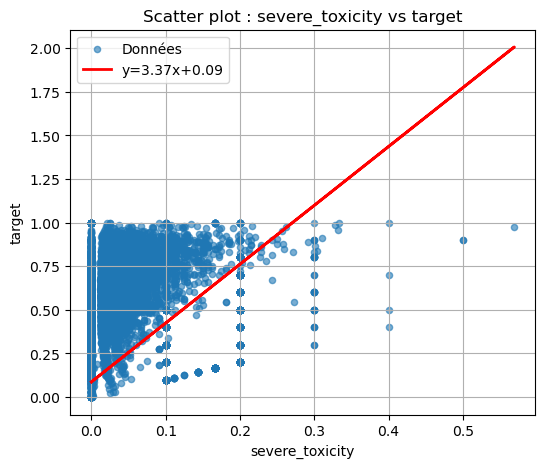

In [25]:
scatter_plot(train, "severe_toxicity", "target", sample_fraction=0.1)

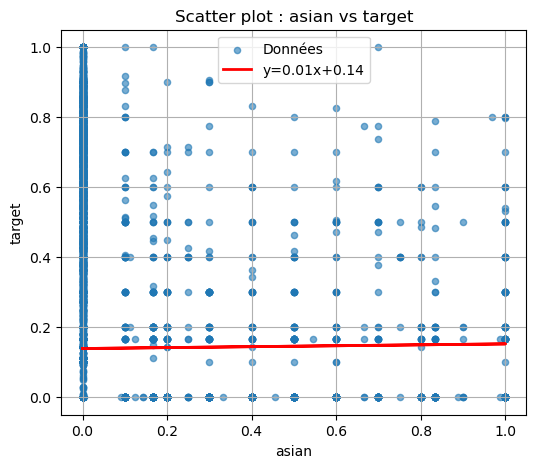

In [26]:
scatter_plot(train, "asian", "target", sample_fraction=0.1)


# 1. Approche Classique Spark ML sur la colonne "comments"

Stratégie pour le prétraitement : 
1. Prétraitement de la colonne "comments", cela passe par un nettoyage avec Spark SQL et regex, puis une tokenisation. On enlève ensuite les stop words puis on utilise un transformer SparkML personnalisé pour la lemmatisation

2. Pour la colonne "Target" : création d’une variable binaire label --> when(col("target") >= 0.5, 1).otherwise(0) --> pour le modèle de regression logistique

4. On s'occupe des features secondaires. Dans la partie précédente on avait identifié 3 types de features :

- Les sous-labels de toxicité --> **float entre [0,1]**
- Les colonnes d'identité --> **float entre [0,1]**
- Les colonnes temporelles --> **timestamp**
- Les features liées aux métadonnées --> **numériques mais catégorielles**
- Colonnes liées aux réactions --> compteurs d’interactions, **int**
- Nombre d'annotateurs sur un commentaire donné (mesure de la confiance des labels) --> **int**


## 1.1 Prétraitement de la colonne "comments"

--> utilisation d'une fonctions UDF afin que le traitement reste distribué sur les workers (pas d'utilisation de pandas sauf pour l'affichage d'un échantillon des données 

--> on fait tout le prétraitement dans spark

--> utilisation de Transformers spark ML pour l'encapsculation dans un pipeline --> structure robuste et modulaire

--> Encapsulation dans un pipeline --> structure robuste et modulaire


#### 1.1.1 Définition d'un Transformer SPark ML pour la lemmatisation

Il n'y a pas d'objet Mlib natif dans Spark ML permettant de faire une lemmatisation.
Pour pouvoir encapsuler cette étape dans le pipeline spark, nous ne pouvons pas utiliser une UDF python classique.
Nous avons donc créé un Transformer Spark ML personnalisé "Lemmatizer", utilisant WordNetLemmatiser et compatible avec le pipeline Spark

In [62]:
from pyspark.ml import Transformer
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

lemm = WordNetLemmatizer()

class Lemmatizer(Transformer, DefaultParamsReadable, DefaultParamsWritable):

    def __init__(self, inputCol="tokens", outputCol="lemmatized"):
        super(Lemmatizer, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        lemm = WordNetLemmatizer()
        lemm_udf = udf(lambda tokens: [lemm.lemmatize(w) for w in tokens], ArrayType(StringType()))
        return df.withColumn(self.outputCol, lemm_udf(df[self.inputCol]))


### 1.1.2 Définition de la fonction Preprocess

In [63]:
def preprocess(df, limit=None, debug=False):
    """
    Nettoyage (tout en minuscule + suppression de tous les caractères non alphabétiques) --> tokenisation --> stopwords --> lemmatisation → conversion de target en binaire
    Retourne un df contenant : tokens, target, label
    """
    # Pour choisir la taille de l'échantillon du dataset
    if limit:
        df = df.limit(limit)

    # Nettoyage du texte (Spark SQL + regex)
    regex_cleaner = SQLTransformer(
        statement="""
            SELECT *,
            regexp_replace(lower(comment_text), '[^a-z ]', '') AS clean_text
            FROM __THIS__
        """
    )

    tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered")
    lemmatizer = Lemmatizer(inputCol="filtered", outputCol="tokens")

    # Pipeline de preprocessing 
    preprocess_pipeline = Pipeline(stages=[
        regex_cleaner,
        tokenizer,
        remover,
        lemmatizer
    ])

    df_prep = preprocess_pipeline.fit(df).transform(df)

    # Target --> binarisation
    # Spark ML reglog = classif binaire --> on doit convertir la colonne target en binaire pour le modèle baseline, meme si cela nous fait perdre de l'information
    df_prep = df_prep.withColumn(
        "label",
        when(col("target") >= 0.5, 1).otherwise(0)
    )

    # Pour voir les différentes étapes du préprocessing
    if (debug == True):

        print("\n>>> AFFICHAGE DES DIFFERENTES ETAPES DU PREPROCESSING")
        
        print("\n# 1) regex_cleaner")
        df1_debug = regex_cleaner.transform(train)
        df1_debug.select("clean_text").show(5, truncate=False)
        
        print("\n# 2) tokenizer")
        df2_debug = tokenizer.transform(df1_debug)
        df2_debug.select("words").show(5, truncate=False)
        
        print("\n# 3) stopwords remover")
        df3_debug = remover.transform(df2_debug)
        df3_debug.select("filtered").show(5, truncate=False)
        
        print("\n# 4) lemmatizer (UDF)")
        df4_debug = lemmatizer.transform(df3_debug)
        df4_debug.select("tokens").show(5, truncate=False)

        print("------------------------------------------------------")


        
    return df_prep

## 1.2 Prétraitement des colonnes secondaires


In [96]:
from pyspark.sql.functions import col, log1p, year, month, dayofweek, hour
from pyspark.ml.feature import StringIndexer, OneHotEncoder

def preprocess_all(df, limit=None):
    """
    Prétraitement pour les colonnes restantes
    """

    if limit:
        df = df.limit(limit)
    
    # 1. Colonnes de toxicité ---
    toxicity_cols = [
        "severe_toxicity", "obscene", "identity_attack", "insult",
        "threat", "sexual_explicit"
    ]
    # Pas de traitement, elles sont déjà dans [0,1] et pas de valeurs manquantes
    
    # 2. Colonnes d'identité
    identity_cols = [
        "asian", "atheist", "bisexual", "black", "buddhist", "christian",
        "female", "heterosexual", "hindu", "homosexual_gay_or_lesbian",
        "intellectual_or_learning_disability", "jewish", "latino", "male",
        "muslim", "other_disability", "other_gender", "other_race_or_ethnicity",
        "other_religion", "other_sexual_orientation", "physical_disability",
        "psychiatric_or_mental_illness", "transgender", "white"
    ]
    # Remplacer les valeurs nulles par 0
    df = df.fillna({c: 0 for c in identity_cols})
    
    # 3. Colonnes de réactions 
    reaction_cols = ["funny", "wow", "sad", "likes", "disagree"]
    
    # on applique une fonction log
    for c in reaction_cols:
        df = df.withColumn(f"{c}_log", log1p(col(c)))
    
    # 4. rating (string)
    df = df.withColumn("decision", when(col("rating") == "approved", 1).otherwise(0))
    df = df.drop("rating")

    
    # 5. created_date (timestamp) 
    df = df.withColumn("year", year("created_date")) \
           .withColumn("month", month("created_date")) \
           .withColumn("dow", dayofweek("created_date")) \
           .withColumn("hour", hour("created_date"))
    
    # 6. IDs 
    id_cols = ["parent_id", "article_id", "publication_id"]
    df = df.fillna({c: 0 for c in id_cols})

    # Ne rien faire, à utiliser uniquement pour groupBy
    
    # 7. Annotator counts 
    # Pas de traitement, éventuellement filtrer
    # df = df.filter(col("toxicity_annotator_count") >= 3)
    
    return df

## 1.3 Split des données 

3 sous ensembles : train, test et val pour l'apprentissage des hyperparamètres

In [65]:
def split_data(df, seed=50):
    """
    Split train/validation/test (70/15/15)
    """
    return df.randomSplit([0.7, 0.15, 0.15], seed=seed)

## 1.4 Vectorisation et Modélisation

CountVectoriser + IDF + Modèle baseline : Regression Logistique

### 1.4.1 Pipeline baseline : CountVectorizer + IDF + RegLog

On aurait aussi pu utiliser un hashing à la place de TF-IDF comme vu dans le cours

In [66]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression

def build_pipeline():
    """
    Pipeline ML complet : TF-IDF --> RegLog
    """
    # transforme les tokens en vecteurs numériques ; listes --> sparse vector
    cv = CountVectorizer(
        inputCol="tokens",
        outputCol="raw_features",
        vocabSize=100000, #largeur voc
        minDF=5 # on garde que quand dans 5 commentaires ou +, pour réduire le bruit
    )

    idf = IDF(inputCol="raw_features", outputCol="features")

    lr = LogisticRegression(
        featuresCol="features",
        labelCol="label",
        maxIter=50,
        regParam=0.0
    )

    return Pipeline(stages=[cv, idf, lr])

## Main code

In [67]:
PREPROCESSED_PATH = "data/preprocessed.parquet" 
MODEL_PATH = "models/tfidf_logreg"
ALL_PREPROCESSED_PATH = "data/all_preprocessed.parquet" 

SAVE_PREPROCESSED = True  # mettre True pour sauvegarder le preprocessing dans un parquet
LOAD_PREPROCESSED = False  # mettre True pour charger un fichier existant

SAVE_MODEL = False  # meme chose        
LOAD_MODEL = True 

### Prétraitement

In [99]:
# 1. Prétraitement (ou chargement)
if LOAD_PREPROCESSED and os.path.exists(PREPROCESSED_PATH):
    print(f"Chargement des données prétraitées depuis : {PREPROCESSED_PATH}")
    df_clean = spark.read.parquet(PREPROCESSED_PATH)

else:
    print("Prétraitement...")
    df_preprocess_comments = preprocess(train, limit=10000, debug=True)   # debug = True pour afficher toutes les étapes
    df_clean = df_clean.select("tokens", "target", "label")
    if SAVE_PREPROCESSED:
        print(f"Sauvegarde des données prétraitées --> {PREPROCESSED_PATH}")
        df_clean.write.mode("overwrite").parquet(PREPROCESSED_PATH)

print("\n>>>Prétraitement de df_clean OK")
df_clean.show(5, truncate=False)

Prétraitement...

>>> AFFICHAGE DES DIFFERENTES ETAPES DU PREPROCESSING

# 1) regex_cleaner
+-----------------------------------------------------------------------------------------------------------+
|clean_text                                                                                                 |
+-----------------------------------------------------------------------------------------------------------+
|this is so cool its like would you want your mother to read this really great idea well done               |
|thank you this would make my life a lot less anxietyinducing keep it up and dont let anyone get in your way|
|this is such an urgent design problem kudos to you for taking it on very impressive                        |
|is this something ill be able to install on my site when will you be releasing it                          |
|haha you guys are a bunch of losers                                                                        |
+---------------------------

+----------------------------------------------------------------------------------+
|tokens                                                                            |
+----------------------------------------------------------------------------------+
|[cool, like, want, mother, read, really, great, idea, well, done]                 |
|[thank, make, life, lot, less, anxietyinducing, keep, dont, let, anyone, get, way]|
|[urgent, design, problem, kudos, taking, impressive]                              |
|[something, ill, able, install, site, releasing]                                  |
|[haha, guy, bunch, loser]                                                         |
+----------------------------------------------------------------------------------+
only showing top 5 rows
------------------------------------------------------
Sauvegarde des données prétraitées --> data/preprocessed.parquet



>>>Prétraitement de df_clean OK


[Stage 597:>                                                        (0 + 1) / 1]

+----------------------------------------------------------------------------------+------------------+-----+
|tokens                                                                            |target            |label|
+----------------------------------------------------------------------------------+------------------+-----+
|[cool, like, want, mother, read, really, great, idea, well, done]                 |0.0               |0    |
|[thank, make, life, lot, less, anxietyinducing, keep, dont, let, anyone, get, way]|0.0               |0    |
|[urgent, design, problem, kudos, taking, impressive]                              |0.0               |0    |
|[something, ill, able, install, site, releasing]                                  |0.0               |0    |
|[haha, guy, bunch, loser]                                                         |0.8936170212765957|1    |
+----------------------------------------------------------------------------------+------------------+-----+
only showi

In [98]:
# 1.1 Prétraitement des autres colonnes
print("\n>>>Prétraitement du df complet :\n")
df_all = preprocess_all(df_preprocess_comments, limit=10000)

cols_to_show = ["severe_toxicity", "obscene","asian", "female","likes", "likes_log", "decision","created_date", "year", "month", "dow", "hour",
"parent_id", "article_id"]

df_all.select(cols_to_show).show(10, truncate=10)

print(df_all.columns)




>>>Prétraitement du df complet :

+---------------+----------+-----+------+-----+----------+--------+------------+----+-----+---+----+---------+----------+
|severe_toxicity|   obscene|asian|female|likes| likes_log|decision|created_date|year|month|dow|hour|parent_id|article_id|
+---------------+----------+-----+------+-----+----------+--------+------------+----+-----+---+----+---------+----------+
|            0.0|       0.0|  0.0|   0.0|    0|       0.0|       0|  2015-09...|2015|    9|  3|  10|      0.0|      2006|
|            0.0|       0.0|  0.0|   0.0|    0|       0.0|       0|  2015-09...|2015|    9|  3|  10|      0.0|      2006|
|            0.0|       0.0|  0.0|   0.0|    0|       0.0|       0|  2015-09...|2015|    9|  3|  10|      0.0|      2006|
|            0.0|       0.0|  0.0|   0.0|    0|       0.0|       0|  2015-09...|2015|    9|  3|  10|      0.0|      2006|
|     0.02127...|       0.0|  0.0|   0.0|    1|0.69314...|       0|  2015-09...|2015|    9|  3|  10|      0.0| 

### Modélisation

In [70]:
# 2. Split des données
train_df, val_df, test_df = split_data(df_clean)
print("\n>>> Split OK")
print(f"Train = {train_df.count()} | Val = {val_df.count()} | Test = {test_df.count()}")

# 3. Pipeline
pipeline = build_pipeline()
print("\n>>> Pipeline OK")

# 4. Entrainement (ou chargement) du modèle
if LOAD_MODEL and os.path.exists(MODEL_PATH):
    print(f"Chargement du modèle existant : {MODEL_PATH}")
    model = PipelineModel.load(MODEL_PATH)

else:
    print("Entrainement du modèle...")
    model = pipeline.fit(train_df)
    print(">>> Modèle entraîné OK")

    if SAVE_MODEL:
        print(f"Sauvegarde du modèle --> {MODEL_PATH}")
        model.write().overwrite().save(MODEL_PATH)

# 5. Test du modèle
preds = model.transform(test_df)
print("\n>>> Prédictions OK")
preds.select("tokens", "target", "label", "probability", "prediction").show(truncate=40)

# 6. Evaluation ROC-AUC
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(preds)
print(f"\n>>> Baseline ROC-AUC = {auc:.4f}")


>>> Split OK


Train = 6956 | Val = 1552 | Test = 1492

>>> Pipeline OK
Chargement du modèle existant : models/tfidf_logreg

>>> Prédictions OK


+----------------------------------------+------+-----+----------------------------------------+----------+
|                                  tokens|target|label|                             probability|prediction|
+----------------------------------------+------+-----+----------------------------------------+----------+
|[story, get, ridiculous, hour, love, ...|   0.5|    1|[4.654841133767605E-15,0.999999999999...|       1.0|
|[commenting, sake, commenting, rate, ...|   0.0|    0|[0.999997122516134,2.8774838659595403...|       0.0|
|[interesting, concepthow, civil, comm...|   0.0|    0|[0.9999999594126746,4.058732538947396...|       0.0|
|[awesome, signed, give, shot, good, l...|   0.0|    0|                               [1.0,0.0]|       0.0|
|[wmcelha, several, new, exciting, veg...|   0.0|    0|                               [1.0,0.0]|       0.0|
|[quite, comprehensive, list, goody, w...|   0.0|    0|[0.9999999990218311,9.781688792287468...|       0.0|
|[tuesday, jan, , member, so

[Stage 499:>                                                        (0 + 1) / 1]


>>> Baseline ROC-AUC = 0.9205


### Pour sauvegarder le modèle ou les données preprocessed  

Cette cellule peut être executée à nimporte quel moment pour sauvegarder un modèle/un df de data preprocessed

In [71]:
# print(f"Sauvegarde des données prétraitées --> {PREPROCESSED_PATH}")
# df_clean.write.mode("overwrite").parquet(PREPROCESSED_PATH)

# print(f"Sauvegarde du modèle --> {MODEL_PATH}")
# model.write().overwrite().save(MODEL_PATH)

## 1.3 Optimisation des hyperparamètres

## 1.4 Optimisation et validation


# 2. Analyse du biais et métriques d’équité


# 3. Interprétabilité et robustesse


# 4. Approche moderne : Transformers (BERT)


# 5. Comparaison et évaluation des modèles

# 6. Amélioration et hybridation

# 7. Soumission Kaggle et documentation